In [18]:
# Import Dependencies
import numpy as np
import pandas as pd
import sklearn
import os

# NLTK Dependencies
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# SKLearn Dependencies
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix


import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to /home/joseph/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/joseph/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/joseph/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [9]:
data_dir = 'data_reviews'
x_train_embeddings = np.load(os.path.join(data_dir, 'x_train_BERT_embeddings.npy'))
x_test_embeddings = np.load(os.path.join(data_dir, 'x_test_BERT_embeddings.npy'))
y_train_raw = np.loadtxt(os.path.join(data_dir, "y_train.csv"), skiprows=1, delimiter=",", dtype=int)

In [10]:
print(f'x_train_embeddings shape: {x_train_embeddings.shape}')
print(f'y_train_raw shape: {y_train_raw.shape}')
print(f'x_test_embeddings shape: {x_test_embeddings.shape}')

x_train_embeddings shape: (2400, 768)
y_train_raw shape: (2400,)
x_test_embeddings shape: (600, 768)


In [12]:
# Split for heledout data
X_train, X_val, y_train, y_val = train_test_split(x_train_embeddings, y_train_raw, test_size=0.25, random_state=42)

In [14]:
print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_val shape: {X_val.shape}')
print(f'y_val shape: {y_val.shape}')

X_train shape: (1800, 768)
y_train shape: (1800,)
X_val shape: (600, 768)
y_val shape: (600,)


<font size="10">Preprocessing steps</font>

In [20]:
cv_kfold = KFold(n_splits=10, shuffle=True, random_state=42)

In [29]:
base = Pipeline([('estimator', RandomForestClassifier(random_state=42))])

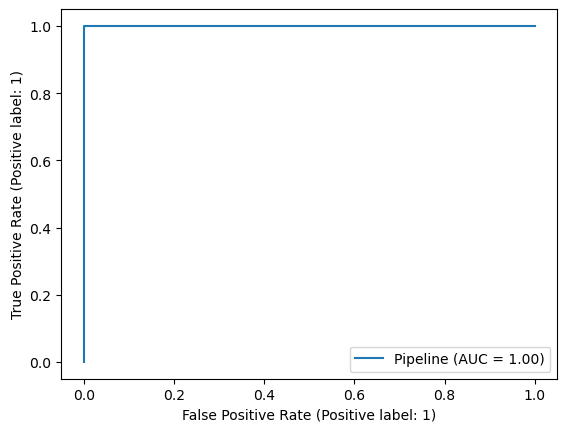

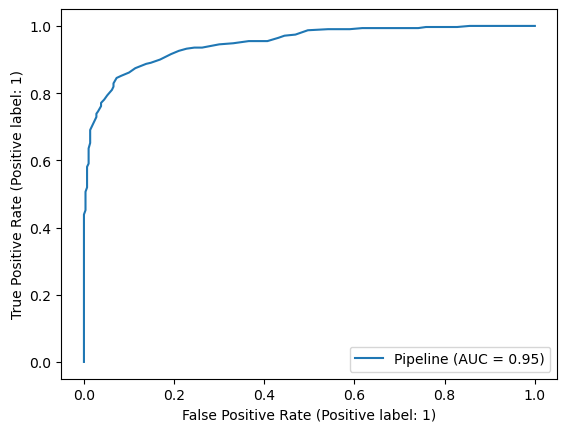

In [32]:
base.fit(X_train, y_train)

base_AUROC_train = RocCurveDisplay.from_estimator(base, X_train, y_train)
base_AUROC_val = RocCurveDisplay.from_estimator(base, X_val, y_val)
plt.show()

In [33]:
param_grid = [{ 'estimator' : [RandomForestClassifier(random_state=42, n_jobs=-1)], 
                'estimator__max_depth': [2,5,10,20],
                'estimator__min_samples_leaf': [1,2,5,10,20],
                'estimator__n_estimators': [10,30,50,100,200]}]

refined_search = GridSearchCV(
    base,
    param_grid=param_grid,
    cv=cv_kfold,
    scoring='roc_auc',
    refit=True,
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

In [34]:
refined_search.fit(X_train, y_train)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('estimator',
                                        RandomForestClassifier())]),
             n_jobs=-1,
             param_grid=[{'estimator': [RandomForestClassifier(max_depth=20,
                                                               min_samples_leaf=2,
                                                               n_estimators=200,
                                                               n_jobs=-1,
                                                               random_state=42)],
                          'estimator__max_depth': [2, 5, 10, 20],
                          'estimator__min_samples_leaf': [1, 2, 5, 10, 20],
                          'estimator__n_estimators': [10, 30, 50, 100, 200]}],
             return_train_score=True, scoring='roc_auc', verbose=1)

In [37]:
best_params = refined_search.best_params_
display(best_params)

{'estimator': RandomForestClassifier(max_depth=20, min_samples_leaf=2, n_estimators=200,
                        n_jobs=-1, random_state=42),
 'estimator__max_depth': 20,
 'estimator__min_samples_leaf': 2,
 'estimator__n_estimators': 200}

In [36]:
cols = ['param_estimator',
        'param_estimator__max_depth',
        'param_estimator__min_samples_leaf',
        'param_estimator__n_estimators',
        'mean_test_score',
        'mean_train_score']


pd.options.display.max_colwidth = 50

grid_search_base_results = pd.DataFrame(refined_search.cv_results_).sort_values(by = 'mean_test_score', ascending = False)
grid_search_base_results[cols].head(10)

,param_estimator,param_estimator__max_depth,param_estimator__min_samples_leaf,param_estimator__n_estimators,mean_test_score,mean_train_score
84,"RandomForestClassifier(max_depth=20, min_sampl...",20,2,200,0.953774,1.000000
59,"RandomForestClassifier(max_depth=20, min_sampl...",10,2,200,0.952453,1.000000
79,"RandomForestClassifier(max_depth=20, min_sampl...",20,1,200,0.952350,1.000000
88,"RandomForestClassifier(max_depth=20, min_sampl...",20,5,100,0.952165,0.999949
54,"RandomForestClassifier(max_depth=20, min_sampl...",10,1,200,0.951937,1.000000
78,"RandomForestClassifier(max_depth=20, min_sampl...",20,1,100,0.951707,1.000000
63,"RandomForestClassifier(max_depth=20, min_sampl...",10,5,100,0.951394,0.999932
64,"RandomForestClassifier(max_depth=20, min_sampl...",10,5,200,0.951110,0.999948
89,"RandomForestClassifier(max_depth=20, min_sampl...",20,5,200,0.951068,0.999967
69,"RandomForestClassifier(max_depth=20, min_sampl...",10,10,200,0.950219,0.999028


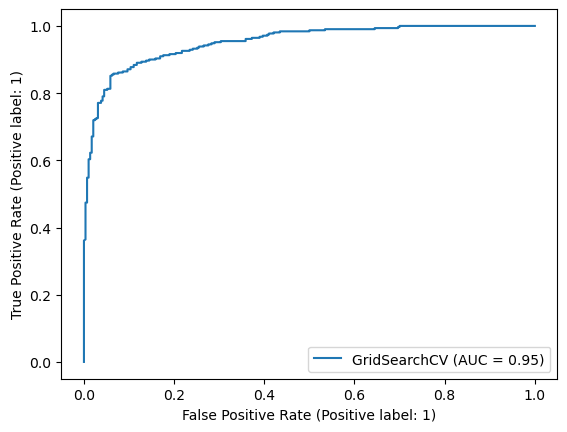

In [39]:
refined_best_AUROC_val = RocCurveDisplay.from_estimator(refined_search, X_val, y_val)
plt.show()

In [40]:
plt(refined_best_AUROC_val)

TypeError: 'module' object is not callable

In [41]:
yhat_test_proba = refined_search.predict_proba(x_test_embeddings)
display(yhat_test_proba[:,1])
pos_rate_yhat_test_proba = yhat_test_proba[:,1]

array([0.26675   , 0.4675    , 0.30116667, 0.32166667, 0.1813003 ,
       0.31840476, 0.39666667, 0.24216667, 0.23266667, 0.64408333,
       0.33875   , 0.44833333, 0.21391667, 0.26566667, 0.1908683 ,
       0.159182  , 0.42384867, 0.18059867, 0.28126534, 0.2765    ,
       0.33383333, 0.3175    , 0.34159867, 0.23076534, 0.39575   ,
       0.41552381, 0.2971183 , 0.19875   , 0.12413364, 0.30795163,
       0.36666667, 0.33751534, 0.22759867, 0.23126534, 0.33541667,
       0.09751534, 0.37126534, 0.14642857, 0.404432  , 0.36533333,
       0.22251534, 0.16584867, 0.24334867, 0.20194516, 0.38053497,
       0.29633333, 0.42941667, 0.30001534, 0.3958683 , 0.12413364,
       0.4225    , 0.30408333, 0.2213003 , 0.41608333, 0.20625   ,
       0.53408333, 0.33991667, 0.36626534, 0.3715    , 0.235     ,
       0.47961905, 0.16383333, 0.27708333, 0.17311183, 0.22213364,
       0.091682  , 0.26358333, 0.39934867, 0.27383333, 0.51666667,
       0.27308333, 0.44483333, 0.20559649, 0.29696697, 0.35916

In [42]:
# print to text file
np.savetxt('yproba1_test_p2_BERT.txt', pos_rate_yhat_test_proba) # don't add delimeter, since the load can't take delimiter